### Metrics of Interest

- Sidewalk damage (‘HARDSCAPE’ in dataset)
- Density of trees
- Vacant lots
- Species diversity
- Health of trees


In [59]:
%matplotlib inline

import pandas as pd
import numpy as np

In [60]:
# read in data 
fuf = pd.read_csv('../data/combined_tree_data_with_header_with_derived_neighborhood.csv').fillna('')
fuf = fuf.rename(columns={'derived_neighborhood':'neighborhood'})

In [61]:
fuf['hardscape_metric'] = fuf['hardscape_damage'].apply(lambda x: 0 if x in ['None', 'No', 'NA'] else 1)
fuf['vacant_lot_metric'] = fuf['condition'].apply(lambda x: 0 if x != 'Vacancy' else 1)
fuf['condition_metric'] = fuf['condition'].apply(lambda x: 0 if x in ['Poor','Dead', 'Critical'] else 1)
fuf['stump_metric'] = fuf['condition'].apply(lambda x: 1 if x in ['Stump', 'Stump Removal'] else 0)
grouped = fuf[['hardscape_metric','diameter_at_breast_height','neighborhood',
          'vacant_lot_metric', 'condition_metric', 'stump_metric']].groupby('neighborhood').mean().reset_index()
joined = pd.merge(fuf, grouped, on='neighborhood', how = 'left', suffixes=('_binary','_perc'))

### Sidewalk Damage

In [62]:
fuf.hardscape_damage.value_counts()

None                  50271
No                    30438
Sidewalk/CG            9626
Sidewalk               7780
Yes                    6418
                       6230
Curb/Gutter            1320
Temporary               148
Other                    41
Private                  30
Well Grate / Cover       27
Temporary/CG              1
0                         1
Name: hardscape_damage, dtype: int64

In [63]:
fuf['hardscape_metric'] = fuf['hardscape_damage'].apply(lambda x: 0 if x in ['None','No', 'NA'] else 1)

hardscape = fuf.groupby('neighborhood')['hardscape_metric'].mean().reset_index()

### Diversity

In [65]:
from __future__ import division

# when the condition of the tree is bad, the species is reported in a weird way. remove those.
bad_condition = ['dead', 'vacancy', 'stump', 'unsuitable site', 'stump removal', 'open']
fuf.ix[fuf.scientific_species_name<>'', 'genus'] = fuf[fuf.scientific_species_name<>''].scientific_species_name.apply(lambda x: x.split()[0])
diversity = fuf[~fuf.condition.isin(bad_condition)].groupby(['neighborhood', 'genus']).size().reset_index().rename(columns={0:'cnt'})
cnts = fuf[~fuf.condition.isin(bad_condition)].groupby(['neighborhood']).size().reset_index().rename(columns={0:'cnt'})

diversity = pd.merge(diversity,cnts,on='neighborhood')
diversity['pct'] = diversity.apply(lambda x: x.cnt_x/x.cnt_y, axis=1)
diversity['not_diverse'] = diversity.pct.apply(lambda x: 1 if x>=.2 else 0)
diversity = diversity.groupby('neighborhood').not_diverse.sum().reset_index()

### Vacant Lots

In [66]:
fuf['vacant_lot_metric'] = fuf['condition'].apply(lambda x: 0 if x != 'Vacancy' else 1)
vacant = fuf.groupby('neighborhood')['vacant_lot_metric'].mean().reset_index()

### Health of trees

In [67]:
fuf.condition.value_counts()

Fair               28211
Poor               23342
Fair               19532
Good               12634
Good               11061
Vacancy             8666
                    3395
Poor                1877
Dead                 741
Very Good            738
Very                 708
Dead                 369
Stump                313
Stump Removal        222
Excellent            175
Critical             120
Open                 106
Critical              85
Unsuitable Site       35
6/15/16                1
Name: condition, dtype: int64

In [ ]:
#assuming very = very good
from collections import defaultdict
condition_score = defaultdict(lambda: '' )
csd = {
    'dead':0,
    'critical':1,
    'poor':2,
    'fair':3,
    'good':4,
    'very':5,
    'very good':5,
    'excellent':6
}
for c in csd:
    condition_score[c] = csd[c]

In [68]:
fuf['condition_score'] = fuf.condition.apply(lambda x: condition_score[x.lower().strip()])
condition = fuf[fuf.condition_score<>'']
condition['condition_score'] = condition.condition_score.astype(int)
condition = condition.groupby('neighborhood')['condition_score'].mean().reset_index()

/Users/spencer/Documents/Personal/datasci-street-tree-viz/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


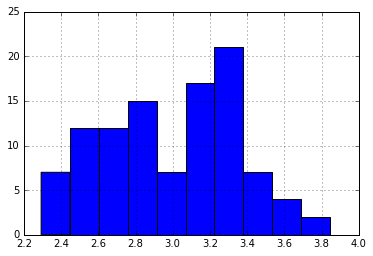

In [69]:
condition.condition_score.hist()

In [70]:
inv_csd = {v: k for k, v in csd.iteritems()}
condition['condition_lable'] = condition.condition_score.apply(lambda x: inv_csd[int(round(x))] if x else x)

### Density

In [71]:
#neighborhood areas courtesy of Spencer (units unknown)

neighborhood_area = """Seacliff, 584559
Lake Street, 486588
Presidio National Park, 7785081
Presidio Terrace, 416901
Inner Richmond, 2873215
Sutro Heights, 713105
Lincoln Park / Ft. Miley, 1575630
Outer Richmond, 3745203
Golden Gate Park, 5535110
Presidio Heights, 728466
Laurel Heights / Jordan Park, 739172
Lone Mountain, 1030917
Anza Vista, 381957
Cow Hollow, 500591
Union Street, 616335
Marina, 1860177
Telegraph Hill, 321562
Downtown / Union Square, 456142
Tenderloin, 677681
Civic Center, 667217
Hayes Valley, 370172
Alamo Square, 313007
Panhandle, 722099
Haight Ashbury, 427566
Lower Haight, 561154
Mint Hill, 193861
Duboce Triangle, 543148
Cole Valley, 234774
Rincon Hill, 478124
South Beach, 879238
South of Market, 3926306
Showplace Square, 804205
Mission Bay, 2032371
Yerba Buena Island, 813945
Treasure Island, 2106231
Mission Dolores, 1075383
Castro, 309558
Outer Sunset, 8933628
Parkside, 3860649
Stonestown, 882009
Parkmerced, 1596457
Lakeshore, 7973826
Golden Gate Heights, 2117466
Forest Hill, 650261
West Portal, 917441
Clarendon Heights, 689473
Midtown Terrace, 696602
Laguna Honda, 1086186
Upper Market, 685945
Dolores Heights, 1181255
Mission, 3947711
Potrero Hill, 2971407
Dogpatch, 537768
Central Waterfront, 3297821
Diamond Heights, 804222
Fairmount, 747602
Peralta Heights, 383378
Holly Park, 568742
Merced Manor, 732556
Balboa Terrace, 351418
Ingleside, 1199810
Merced Heights, 960282
Outer Mission, 992289
Ingleside Terraces, 779681
Mt. Davidson Manor, 289695
Monterey Heights, 333667
Westwood Highlands, 185864
Westwood Park, 718318
Miraloma Park, 1223401
Crocker Amazon, 1834895
McLaren Park, 1730345
Sunnydale, 475674
Visitacion Valley, 1579119
India Basin, 1028498
Hunters Point, 3757633
Candlestick Point SRA, 2009785
Northern Waterfront, 728122
Cayuga, 938958
Oceanview, 1280145
Apparel City, 467624
Bernal Heights, 2186907
Noe Valley, 1839016
Produce Market, 1086990
Bayview, 3265434
Silver Terrace, 1304052
Bret Harte, 1069454
Little Hollywood, 560864
Portola, 2385740
University Mound, 726962
St. Marys Park, 519616
Mission Terrace, 1614676
Excelsior, 2120210
Sunnyside, 1460251
Glen Park, 1136228
Aquatic Park / Ft. Mason, 536736
Fishermans Wharf, 839951
Cathedral Hill, 622632
Japantown, 370871
Pacific Heights, 2268224
Lower Pacific Heights, 769251
Western Addition, 1201797
Chinatown, 403662
Nob Hill, 810649
Lower Nob Hill, 546137
Polk Gulch, 382432
North Beach, 737700
Russian Hill, 1200788
Financial District, 1049942
Inner Sunset, 1425791
Parnassus Heights, 916689
Forest Knolls, 569284
Buena Vista, 861252
Corona Heights, 360528
Ashbury Heights, 435637
Eureka Valley, 961785
St. Francis Wood, 548679
Sherwood Forest, 684025"""

area_df = pd.DataFrame([x.split(',') for x in neighborhood_area.split('\n')], columns=['neighborhood', 'area'])
area_df['area'] = area_df.area.astype(int)
area_df['miles'] = area_df.area/(5280*5280)

In [72]:
# only count trees that don't have a bad condition
density = fuf[~fuf.condition.isin(bad_condition)].groupby('neighborhood').size().reset_index().rename(columns={0:'tree_cnt'})
density = pd.merge(density, area_df, on='neighborhood')
density['density'] = density.apply(lambda x: x.tree_cnt/x.miles, axis=1)

### Join

In [84]:
m = pd.merge(diversity, density, on='neighborhood', how='left')
m = pd.merge(m, condition, on='neighborhood', how='left')
m = pd.merge(m, vacant, on='neighborhood', how='left')
m = pd.merge(m, hardscape, on='neighborhood', how='left')

In [85]:
m

,neighborhood,not_diverse,tree_cnt,area,miles,density,condition_score,condition_lable,vacant_lot_metric,hardscape_metric
0,Alamo Square,0,479.0,313007.0,0.011228,42662.795401,3.192719,fair,0.000000,0.308977
1,Anza Vista,1,496.0,381957.0,0.013701,36202.207055,3.295983,fair,0.000000,0.201613
2,Aquatic Park / Ft. Mason,1,140.0,536736.0,0.019253,7271.686639,2.420290,poor,0.000000,0.442857
3,Ashbury Heights,0,836.0,435637.0,0.015626,53499.455740,2.836634,fair,0.032297,0.416268
4,Balboa Terrace,1,378.0,351418.0,0.012605,29987.181078,2.884058,fair,0.087302,0.264550
5,Bayview,1,1255.0,3265434.0,0.117131,10714.469195,3.363712,fair,0.000000,0.279681
6,Bernal Heights,0,3251.0,2186907.0,0.078444,41443.316245,2.649630,fair,0.037527,0.436481
7,Bret Harte,1,313.0,1069454.0,0.038361,8159.246868,3.494340,fair,0.000000,0.188498
8,Buena Vista,0,1107.0,861252.0,0.030893,35833.169386,2.865403,fair,0.028004,0.407407
9,Castro,0,661.0,309558.0,0.011104,59528.819801,2.470312,poor,0.018154,0.369138


In [86]:
m = m.rename(columns ={'neighborhood':'Neighborhood',
              'not_diverse':'Diversity', 
              'condition_score':'Condition', 
              'vacant_lot_metric':'Vacancies', 
              'hardscape_metric':'Sidewalk Damage',
              'density':'Density',
              'condition_lable':'Condition Label',
              'tree_cnt':'Tree Count'})

m = m[['Neighborhood', 'Density', 'Diversity', 'Condition', 'Condition Label', 'Vacancies', 'Sidewalk Damage', 'Tree Count']]
m = m[~m.Density.isnull()]

In [87]:
m.to_csv("neighborhood_map_metrics.csv")
m

,Neighborhood,Density,Diversity,Condition,Condition Label,Vacancies,Sidewalk Damage,Tree Count
0,Alamo Square,42662.795401,0,3.192719,fair,0.000000,0.308977,479.0
1,Anza Vista,36202.207055,1,3.295983,fair,0.000000,0.201613,496.0
2,Aquatic Park / Ft. Mason,7271.686639,1,2.420290,poor,0.000000,0.442857,140.0
3,Ashbury Heights,53499.455740,0,2.836634,fair,0.032297,0.416268,836.0
4,Balboa Terrace,29987.181078,1,2.884058,fair,0.087302,0.264550,378.0
5,Bayview,10714.469195,1,3.363712,fair,0.000000,0.279681,1255.0
6,Bernal Heights,41443.316245,0,2.649630,fair,0.037527,0.436481,3251.0
7,Bret Harte,8159.246868,1,3.494340,fair,0.000000,0.188498,313.0
8,Buena Vista,35833.169386,0,2.865403,fair,0.028004,0.407407,1107.0
9,Castro,59528.819801,0,2.470312,poor,0.018154,0.369138,661.0


In [ ]:
# Scale metrics from 0-10 for display purposes
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scale_df = m[['Density', 'Diversity', 'Condition', 'Vacancies', 'Sidewalk Damage']]
scale_df = pd.DataFrame(scaler.fit_transform(scale_df), columns=scale_df.columns)*10
scale_df = scale_df.round()

In [ ]:
scale_df['Neighborhood'] = m.Neighborhood

In [ ]:
scale_df.to_csv("neighborhood_map_metrics_normed.csv")

In [ ]:
scale_df